In [1]:
import os
import pandas as pd
import numpy as np
import math as math
import scipy.stats as stats
from scipy.stats import expon
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.stats import norm

##Expected shortfall

Average of the $[(1 - c) * n]$ worst realizations

 Derive a formula for the expected shortfall if gains are normally distributed $N(\mu, \sigma^{2})$.

Normal Distribution:
\begin{equation}
f(x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}
\end{equation}

\begin{equation}
F(x) = \frac{1}{\sqrt{2\pi\sigma^2}}\int_{-\infty}^x e^{-\frac{(t-\mu)^2}{2\sigma^2}} dt
\end{equation}

$$E[X] = \mu, Var[X] = \sigma^2$$

Expected Shortfall:\begin{align*}
ES_{\alpha} &= W_0-E[W|W<W_0-VAR]\\
& = W_0-\frac{\int_{-\infty}^{W_0-VAR}Wf(W)dW}{\int_{-\infty}^{W_0-VAR}f(W)dW}\\
\end{align*}

Derive the formula: Let \begin{align*}
y = \frac{x-\mu}{\sigma}
\end{align*}
We can get \begin{align*}
dy = \frac{dx}{\sigma}, x = {\sigma}y + \mu, dx = {\sigma}dy
\end{align*}
Then
$$
\begin{aligned}
ES_{\alpha} &=\frac{1}{\sqrt{2 \pi \sigma^2}} \int_{-\infty}^{\mu-VaR_\alpha} x \cdot \exp \left(-\frac{(x-\mu)^2}{2 \sigma^2}\right) d x \\
= & \frac{1}{\sqrt{2 \pi \sigma^2}} \int(\sigma y+\mu) \cdot \exp \left(-\frac{(\sigma y+\mu-\mu)^2}{2 \sigma^2}\right) \sigma d y \\
= & \frac{1}{\sqrt{2 \pi \sigma^2}} \int(\sigma y+\mu) \exp \left(-\frac{y^2}{2}\right) \sigma d y \\
= & \frac{1}{\sqrt{2 \pi \sigma^2}} \int \sigma^2 y \exp \left(-\frac{y^2}{2}\right) d y+\frac{1}{\sqrt{2 \pi \sigma^2}} \int \sigma \mu \exp \left(-\frac{y^2}{2}\right) d y \\
= & \mu \int_{-\infty}^{y_0-V a R_{(0,1)}} \frac{1}{\sqrt{2 \pi}} \exp \left(-\frac{y^2}{2}\right) d y+\sigma \int_{-\infty}^{y_0-V a R_{(0,1)}} \frac{1}{\sqrt{2 \pi}} y \exp \left(-\frac{y^2}{2}\right) d y
\end{aligned}
$$
Since
$$\begin{aligned}
y_0 = 0, VaR_\alpha = -z(1-\alpha)=-z(c))
\end{aligned}$$
We continue deriving the above formula, and we can abtain
$$
\begin{aligned}
= & \mu \cdot(1-c)+\left.\sigma \cdot \frac{-1}{\sqrt{2 \pi}} \cdot e^{\frac{-y^2}{2}}\right|_{\infty} ^{z(c)} \\
= & \mu \cdot(1-c)+\sigma \cdot \frac{-1}{\sqrt{2 \pi}} e^{-z(c)^2 / 2}
\end{aligned}
$$
Finally, we can get
$$
E S=y_0-\frac{\mu \cdot(1-c)+\sigma \cdot \frac{-1}{\sqrt{2 \pi}} e^{-z(c)^2 / 2}}{1-c}=-\mu+\sigma \cdot \frac{1}{\sqrt{2 \pi}(1-c)} e^{-z(c)^2 / 2}
$$

The expected shortfall can also be defined as the average of the VaR for all confidence level above c: $ES = \frac{1}{1-c}\int_{c}^{1} VaR_{\alpha}d\alpha$ Prove that this definition is equivalent to the one we have seen in class. Hint: You can use integration by part and a change of variable.

From the definition of VaR and ES, we get
\begin{aligned}
E S & =\frac{1}{1-c} \int_c^1 V a R_\alpha d \alpha \\
& =\frac{1}{1-c} \int_c^1 W_0-F^{-1}(1-\alpha) d \alpha \\
& =W_0-\frac{1}{1-c} \int_c^1 F^{-1}(1-\alpha) d \alpha
\end{aligned}
Cause$$
\begin{aligned}
W=F^{-1}(1-\alpha)
\end{aligned}
$$
We have
$$
d W=-\frac{1}{F^{\prime}\left(F^{-1}(1-\alpha)\right)} d \alpha=-\frac{1}{f\left(F^{-1}(1-\alpha)\right)} d \alpha
$$
Since
$$
d \alpha=-f\left(F^{-1}(1-\alpha)\right) d W=-f(W) d W
$$
and
$$F^{-1}(1-1)=-\infty, F^{-1}(1-c)=W_0-V a R$$
We have
$$
\begin{aligned}
& W_0-\frac{1}{1-c} \int_c^1 F^{-1}(1-\alpha) d \alpha \\
= & W_0-\frac{1}{1-c} \int_{W_0-V a R}^{-\infty}-W f(W) d W \\
= & W_0-\frac{1}{1-c} \int_{-\infty}^{W_0-V a R} W f(W) d W
\end{aligned}
$$

 ## Decomposing the VaR of a portfolio

part 1

Assume you have a portfolio of 2m in asset A, 6m in asset B and 2m in
asset C. What is the VaR of your portfolio? What is the CVaR and DVaR
for each of the assets? Check that the sum of CVaRs coincides with VaR.
Which asset is responsible for the most risk of the portfolio?

**Function draw_returns(N)**

This function simulates returns for a portfolio of three assets over
$𝑁$ periods, distinguishing between normal and special (crisis) years:

*normal_year:* A binomial distribution to simulate 90% normal years and 10% special years.

*normal_ret*: Multivariate normal returns for normal years.

*special_ret*: Multivariate normal returns for special years.

The function then combines these to create a series of returns for the portfolio.

In [2]:
def draw_returns(N):

    # coin flips
    normal_year = np.random.binomial(1, 0.9, N)

    # draw for normal years
    mu = np.array([0.05, 0.05, 0.05])
    Sigma = np.array([[0.09, 0.012, 0.021], [0.012, 0.16, 0.028], [0.021, 0.028, 0.49]])
    normal_ret = np.random.multivariate_normal(mu, Sigma, N)

    # draws for special years
    mu = np.array([-0.1, -0.1, -0.1])
    Sigma = np.array([[0.36, 0.24, 0.42], [0.24, 0.64, 0.56], [0.42, 0.56, 1.96]])
    special_ret = np.random.multivariate_normal(mu, Sigma, N)

    # combine
    ret = normal_ret
    for i in range(N):
        if normal_year[i] == 0:
            ret[i,:] = special_ret[i,:]

    return(ret)

First, for the VaR:

**Portfolio_profit(returns, holdings)**

This function calculates the profit of a portfolio given returns and holdings:
np.dot(returns, holdings): Computes the dot product, which gives the total profit for each set of returns.

**VaR_from_gains(gains, c=0.99)**
This function calculates the Value at Risk (VaR) at confidence level
$c$:

VaR is the maximum expected loss over a given time period at a specific confidence level. It sorts the gains and selects the appropriate quantile based on $c$.

**Portfolio Analysis**

*Initial Holdings:*

holdings_Q1=[2000,6000,2000]

holdings_Q1=[2000,6000,2000]

in thousands of dollars.

**Gains:** Profits from the portfolio given the simulated returns and holdings.

**VaR_Q1**: The Value at Risk for the portfolio with the initial holdings.

Delta VaR (DVaR) Calculations
The effect of increasing the position in each asset by $1000 on VaR:

DVaR_A: Change in VaR when increasing the first asset’s holdings.

DVaR_B: Change in VaR for the second asset.

DVaR_C: Change in VaR for the third asset.

Conditional Value at Risk (CVaR)
CVaR (also called Expected Shortfall) measures the average loss given that the loss exceeds the VaR. It provides a more comprehensive risk measure.

**The calculation:**

Delta: A small increment in asset holdings (0.01 or 1%).

CVaR_A: The conditional VaR for the first asset when its holdings are increased slightly.

**Context:** Value at Risk (VaR) and Conditional Value at Risk (CVaR)
VaR is a threshold value such that the probability that the loss on the portfolio over the given time horizon exceeds this value is the confidence level (e.g., 99%).
CVaR takes this a step further by considering the tail of the loss distribution beyond the VaR, providing a measure of the expected loss in extreme scenarios. It's especially useful in risk management for understanding the potential impact of rare, but severe, losses.

In [3]:
np.random.seed(1234)

# Generate portfolio profits (in 1000 $)
rets = draw_returns(10000)

def portfolio_profit(returns, holdings):
  return(np.dot(returns, holdings))

holdings_Q1 = np.array([2000, 6000, 2000]) # in 1000 $

# Let W0 = 0
gains = portfolio_profit(rets, holdings_Q1)
def VaR_from_gains(gains, c=0.99):
  n = len(gains)
  sort = sorted(gains)
  VaR = -sort[math.ceil(n * (1-c))-1]
  return(VaR)

VaR_Q1 = VaR_from_gains(gains)
VaR_Q1
# VaR is around 10 million $

9956.983483145892

Assuming $W_0$ = 0, the VaR is 9956.983483145892.

Let’s start with DVaR by adding some 1k to the holdings of any one stock.

In [4]:
# asset A: first we add 1000 $ to the first asset holdings
Delta = 1

VaR_new = VaR_from_gains(portfolio_profit(rets, holdings_Q1 + np.array([Delta, 0, 0])))
DVaR_A = (VaR_new - VaR_Q1)/Delta

# VaR increases by 307 $ if we increase position in first asset by 1000$

# asset B:

VaR_new = VaR_from_gains(portfolio_profit(rets, holdings_Q1 + np.array([0, Delta, 0])))
DVaR_B = (VaR_new - VaR_Q1)/Delta

DVaR_B

# VaR increases by 1011 $ if we increase position in second asset by 1000$
# asset C:

0.6708504808684665

In [5]:
VaR_new = VaR_from_gains(portfolio_profit(rets, holdings_Q1 + np.array([0, 0, Delta])))
DVaR_C = (VaR_new - VaR_Q1)/Delta
DVaR_C
# VaR increases by 2072 $ if we increase position in third asset by 1000$

2.034937238724524

Note that these are numerical approximations to a derivative.

Now for CVaR, by changing holdings by 1%.

In [6]:
# asset A: first we add 1000 $ to the first asset holdings
Delta = 0.01
VaR_new = VaR_from_gains(portfolio_profit(rets, holdings_Q1 * np.array([1 + Delta, 1, 1])))
CVaR_A = 100*(VaR_new - VaR_Q1)
CVaR_A

# asset B:

1862.00612048724

In [7]:
VaR_new = VaR_from_gains(portfolio_profit(rets, holdings_Q1 * np.array([1, 1 + Delta, 1])))
CVaR_B = 100*(VaR_new - VaR_Q1)
CVaR_B
# asset C:

4025.1028852100717

In [8]:
VaR_new = VaR_from_gains(portfolio_profit(rets, holdings_Q1 * np.array([1, 1, 1 + Delta])))
CVaR_C = 100*(VaR_new - VaR_Q1)
CVaR_C

4069.874477448866

In [9]:
## Check sum(CVaR) = VaR
(CVaR_A + CVaR_B + CVaR_C)/VaR_new
# small deviation arises from numerical differentiation

0.9959291819997494

This is a numerical approximation, and as observed, there is a significant deviation.

When you approximate the derivatives involved in DVaR and CVaR, vary
the size of the position change you use. What do you observe when you
change the value? Report a graph that shows the effect of different size of
the step for the derivative. Explain what is happening.

How does this depend on Delta. Below you can see show how large the deviation between the sum of CVaR and VaR is for different levels of Delta 0.001%, 0.01%, 0.1%, 1%, and 10%. The smaller Delta, the more precise the result

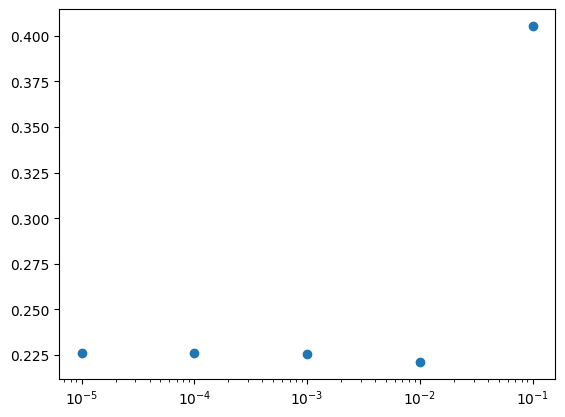

In [11]:
def deviation(Delta):
  # Asset A
  VaR_new = VaR_from_gains(portfolio_profit(rets, holdings_Q1 * np.array([1, 1, 1 + Delta])))
  CVaR_A = (VaR_new - VaR_Q1)/Delta
  # Asset B
  VaR_new = VaR_from_gains(portfolio_profit(rets, holdings_Q1 * np.array([1, 1, 1 + Delta])))
  CVaR_B = (VaR_new - VaR_Q1)/Delta
  # Asset C
  VaR_new = VaR_from_gains(portfolio_profit(rets, holdings_Q1 * np.array([1, 1, 1 + Delta])))
  CVaR_C = (VaR_new - VaR_Q1)/Delta

  return(np.absolute(CVaR_A + CVaR_B + CVaR_C - VaR_new)/VaR_new)


Deltas = np.array([0.00001, 0.0001, 0.001, 0.01, 0.1])
deviations = [deviation(Delta) for Delta in Deltas]

plt.plot(Deltas, deviations, 'o')
plt.xscale('log')
plt.show()


part 3

what happens when we hold 2mn $ in both asset A and B, vis-a-vis 1mn and 3mn in A and B. In particular, is this going to affect the DVaR or CVaR for asset C (the holdings and portfolio weights of asset C are)

In [13]:
holdings_Q3 = np.array([3000, 5000, 2000]) # in 1000 $
gains = portfolio_profit(rets, holdings_Q3)
VaR_Q3 = VaR_from_gains(gains)
VaR_Q3

9565.547422197978

In [14]:
Delta = 1
VaR_new = VaR_from_gains(portfolio_profit(rets, holdings_Q3 + np.array([0, 0, Delta])))
DVaR_C = (VaR_new - VaR_Q3)/Delta
DVaR_C
# VaR increases by 2550 $ if we increase position in third asset by 1000$

3.2698732136959734